In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/MADE/")

# First Task

В данном соревновании вам предстоит решить задачу бинарной классификации. Вам будут даны тренировочная (10000 примеров) и тестовая (2000) выборки. Количество признаков — 30.

Для успешного решения данного задания вам предстоит правильно настроить валидацию, провести отбор признаков и подобрать параметры для итоговой модели.

В результате, необходимо предсказать вероятности положительного класса для данных из тестовой выборки.

# Описание файлов
test.csv — тестовый файл, содержащий идентификаторы пользователи, для которых необходимо сделать предсказания

train.csv — обучающий датасет

train-target.csv — эталон для train.csv.

sample-submission.csv — пример решения (сабмита).

Качество решения оценивается по стандартной метрике ROC-AUC. Код:

from sklearn.metrics import roc_auc_score

score = roc_auc_score(test_target, solution_frame)

На экзамене за данную задачу вы можете получить до 100 баллов. Расчёт баллов производится по формуле:

result = 100 if y > 0.82 else (40 + (y - 0.6) / 0.22 * 60 if y > 0.6 else 0)

где $y$ — это ваш результат по метрике ROC-AUC. Количество баллов является округленным целым числом.

In [53]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [55]:
target = pd.read_csv('target.txt', header=None)
test = pd.read_csv('test.txt', header=None)
train = pd.read_csv('train.txt', header=None)

# **Analysis**

In [5]:
def correlation(data, by="y"):
  return data.corr().sort_values(by=by)[::-1]

def StackModels(final_model, models, X, y, test):
  first_df = pd.DataFrame()
  second_df = pd.DataFrame()

  for i, model in enumerate(models):
    model.fit(X, y)
    first_df[i] = model.predict_proba(X)[:, 1]
    second_df[i] = model.predict_proba(test)[:, 1]

  try:
    final_model.fit(first_df, y)
  except Exception as e:
    return e

  return final_model.predict_proba(second_df)

In [23]:
def histograms(columns, train, test, figsize=(15,30)):
  fig, axes = plt.subplots(len(columns), 2, figsize=figsize)
  for i in range(len(columns)):
    sns.distplot(train[columns[i]], ax = axes[i,0])
    sns.distplot(test[columns[i]], ax = axes[i,1])

def FeatureAnalisis(X, y, model, n):
  rfe = RFE(model, n)
  selector = rfe.fit(X, y)
  result = X.columns[selector.support_]
  return result, selector.ranking_

In [88]:
def HistFeatureImp(model, figsize=(8, 5)):
  plt.figure(figsize=figsize)
  important = model.feature_importances_
  sort = np.argsort(important)[::-1]
  plt.bar(clf.feature_names_, important[sort])

In [15]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-220.530530,-70.197440,119.035181,20.711737,-6.152986,52.225051,-23.230903,-166.521871,-41.571463,2.620401,271.292251,2.695313,44.529272,12.998666,25.157748,2.192931,3.438528,-81.684213,49.566982,-36.818566,16.936420,46.543585,-80.962171,-146.652218,10.899085,4.370985,4.060272,40.680890,-37.942655,33.838225
1,-8.536541,-8.305435,-117.828269,-28.588333,14.223240,-42.087807,-45.538664,58.898976,27.749744,2.545916,-97.233793,-4.899233,-104.382283,2.867261,-128.433975,2.280566,3.412432,31.501910,-47.950176,103.060202,57.027508,121.304258,31.507396,88.282912,66.766185,-4.363974,-5.791376,-32.101939,-52.255449,-4.826111
2,126.229973,133.463504,-105.511797,-149.110267,-3.673355,-104.302244,5.815395,100.838385,-46.240211,0.141700,194.054804,-3.134316,-145.510845,86.972373,-126.200888,0.598976,3.351103,51.084960,141.443443,-150.020696,4.819849,88.905713,51.475105,-73.257358,108.947287,8.567240,0.116269,-117.205053,-107.835928,-93.990332
3,369.571563,11.850181,-299.969407,29.371721,-3.457523,-115.901854,159.134323,-149.741411,-108.847522,0.078277,-215.802195,-1.724561,-128.050861,-99.997710,138.824836,0.460472,1.891893,-73.956562,-116.557681,310.894782,80.930568,-166.476192,-73.882682,108.222355,19.573192,-2.242024,0.515601,-25.218215,121.674228,-16.877368
4,-99.563708,-85.166292,-73.363391,-35.357907,5.437025,-54.892519,56.430532,-49.237377,-50.054608,2.586612,-115.997344,-0.058934,97.666751,36.416791,-124.206264,0.638184,3.989474,-23.264695,-92.966637,121.929801,31.682235,209.163125,-22.847302,-62.067337,58.109167,2.862082,0.920341,-132.875142,3.492953,-15.799596


In [16]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,12.844797,-0.299114,17.445400,-1.089765,0.060510,-0.067073,2.009180,-28.428487,16.467341,1.349504,21.271771,0.009568,-12.566037,0.868286,17.187938,1.077477,3.061034,-13.037922,0.671168,21.573813,0.211515,-2.636170,-13.042007,0.428028,0.999935,-0.153092,0.493480,1.096011,0.690934,-8.751687
std,331.218970,87.840630,166.830889,77.132117,7.079223,95.328230,112.574723,124.090562,141.363732,1.263255,181.467439,2.024503,87.855783,170.544586,117.722386,0.743995,0.846151,62.050977,80.674359,229.410302,46.418509,165.031271,62.060615,82.821135,77.482044,8.557124,1.888925,99.041787,100.623747,78.557761
min,-1625.085835,-285.272638,-670.544061,-287.536745,-25.612006,-404.876372,-395.781633,-514.417062,-526.193023,0.000011,-779.558716,-8.085427,-333.520093,-619.878237,-420.900247,0.001132,0.098466,-254.889907,-314.385808,-819.812924,-196.452972,-766.155471,-255.701616,-362.646319,-276.221505,-31.560708,-9.925537,-381.244544,-388.045812,-338.939731
25%,-186.892257,-60.304200,-90.723945,-52.634237,-4.781103,-65.870246,-74.324525,-110.342167,-78.871151,0.073837,-93.345528,-1.365797,-71.433708,-113.590347,-61.817411,0.490904,2.449836,-54.146848,-53.979555,-132.440268,-31.016369,-115.622198,-54.202381,-56.184700,-51.076999,-5.897427,0.045169,-65.880474,-66.301084,-61.817245
50%,30.376174,-0.576299,18.361277,-1.449727,-0.017278,-1.396145,2.512421,-27.857590,14.174901,2.525594,24.600206,0.005653,-13.759096,-5.891067,15.790737,0.885891,3.049842,-12.724674,0.733288,17.014555,0.459627,-8.188229,-12.628320,0.334218,0.464923,-0.101883,0.492704,0.700402,-4.469156,-10.324727
75%,231.413537,58.639722,126.733466,51.377692,4.827844,63.905144,76.779477,55.226946,110.592913,2.600066,137.302646,1.375353,43.800738,111.017308,95.642441,1.618811,3.747585,28.655681,54.538959,172.038852,31.697139,101.651604,28.586541,55.119716,52.929229,5.634585,0.941508,67.585794,62.984446,43.972321
max,1746.951115,348.103285,786.045193,305.712632,28.931791,351.851613,447.816362,402.650987,598.634382,2.674410,870.338426,8.354485,378.617520,630.578879,465.070306,3.785537,4.988274,202.886675,291.272532,1038.727492,191.379527,681.156385,202.958195,302.583135,264.326359,33.644683,12.157634,418.514443,455.981845,340.571609


In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null  float64
 22 

Text(0.5, 1.0, 'Test')

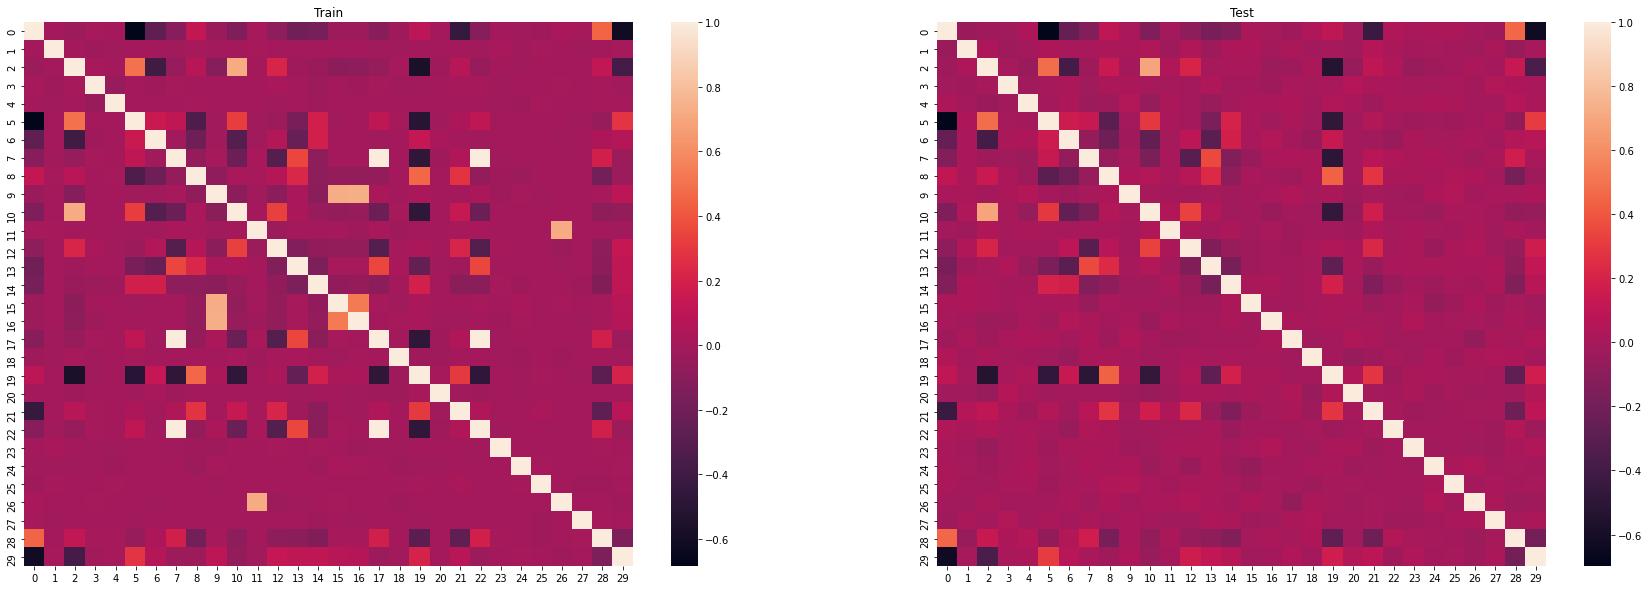

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(train.corr(method="pearson"), ax=axes[0])
axes[0].set_title("Train")
sns.heatmap(test.corr(method="pearson"), ax=axes[1])
axes[1].set_title("Test")

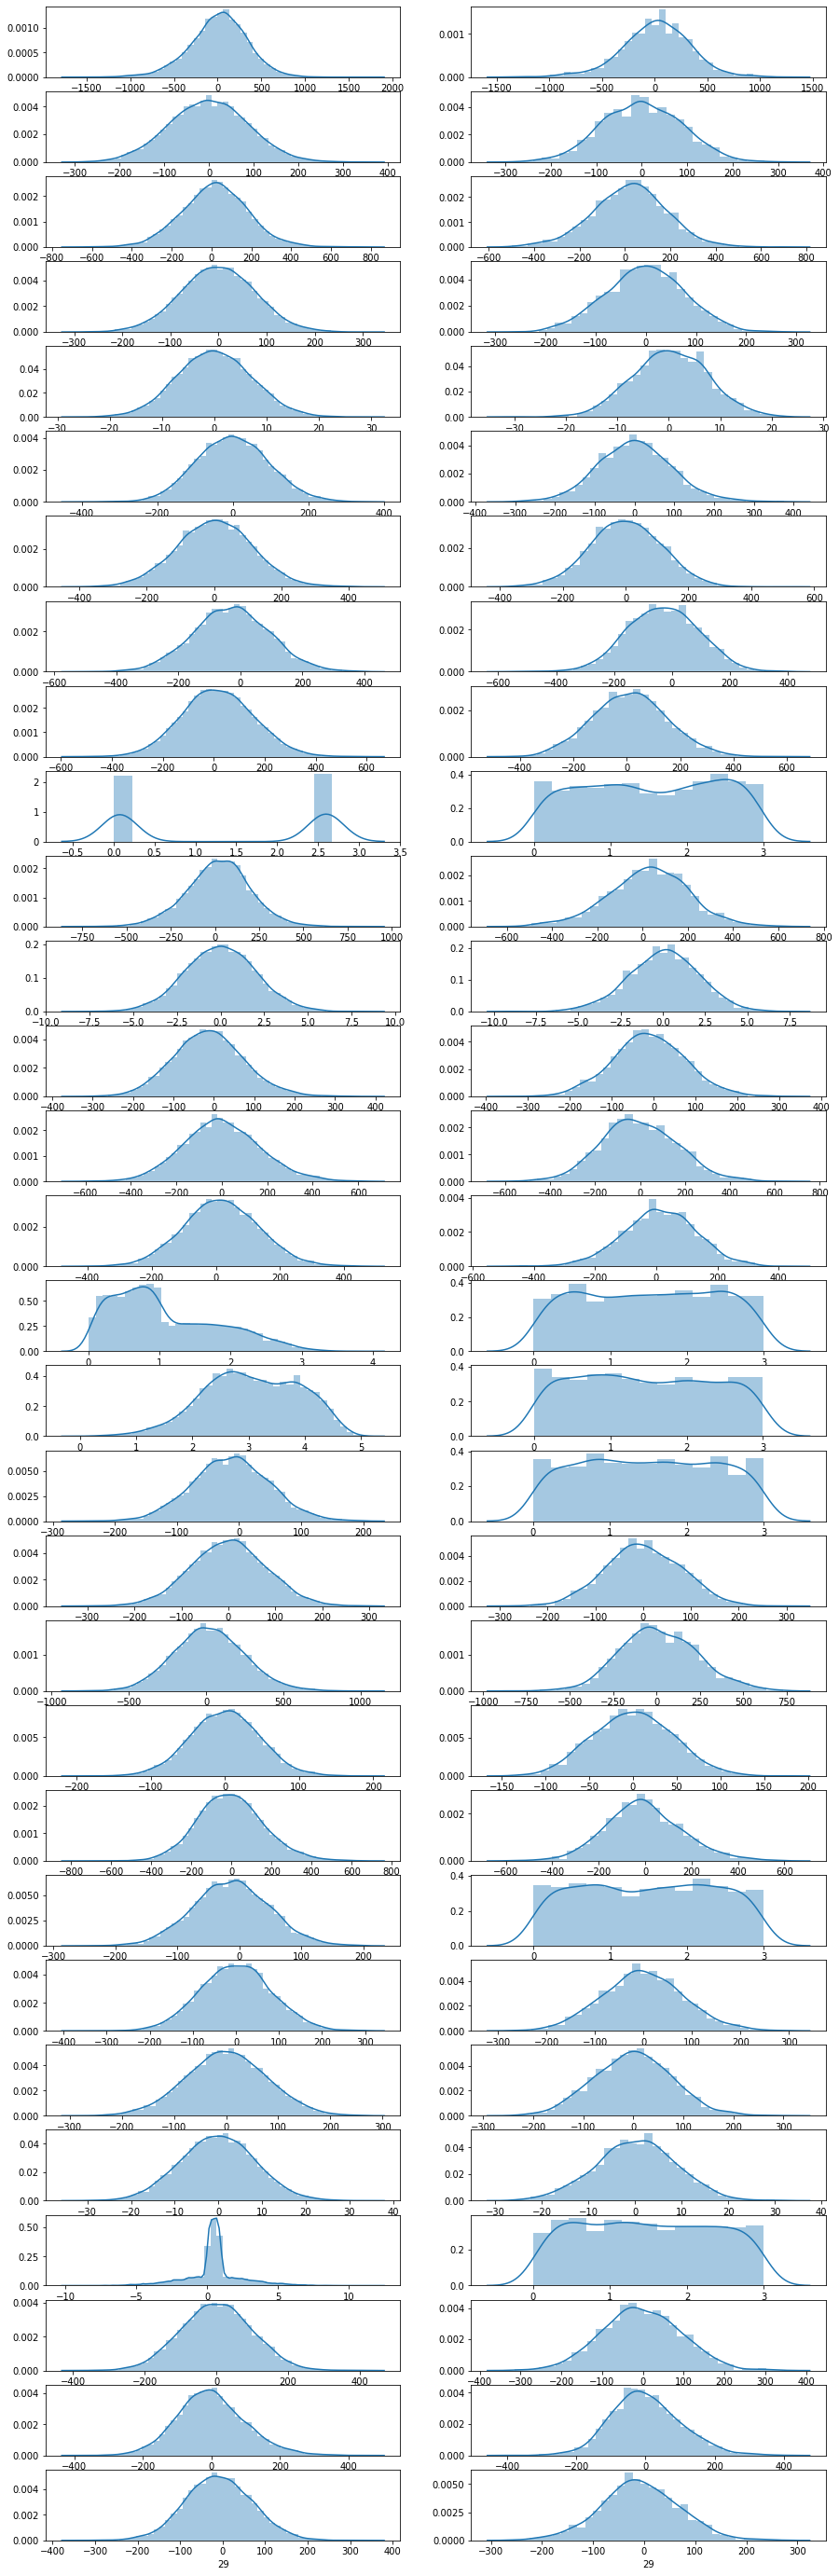

In [25]:
# Посмотрим на распределение наших данных
histograms(train.columns, train, test, (15, 50))

In [56]:
# Заметим, что не все переменные распределены нормально в test и train
# Попробуем найти их с помощью регрессионного анализа
feature = FeatureAnalisis(train, target, LinearRegression(), 7)
print(feature[0])

Int64Index([9, 11, 15, 16, 17, 22, 26], dtype='int64')


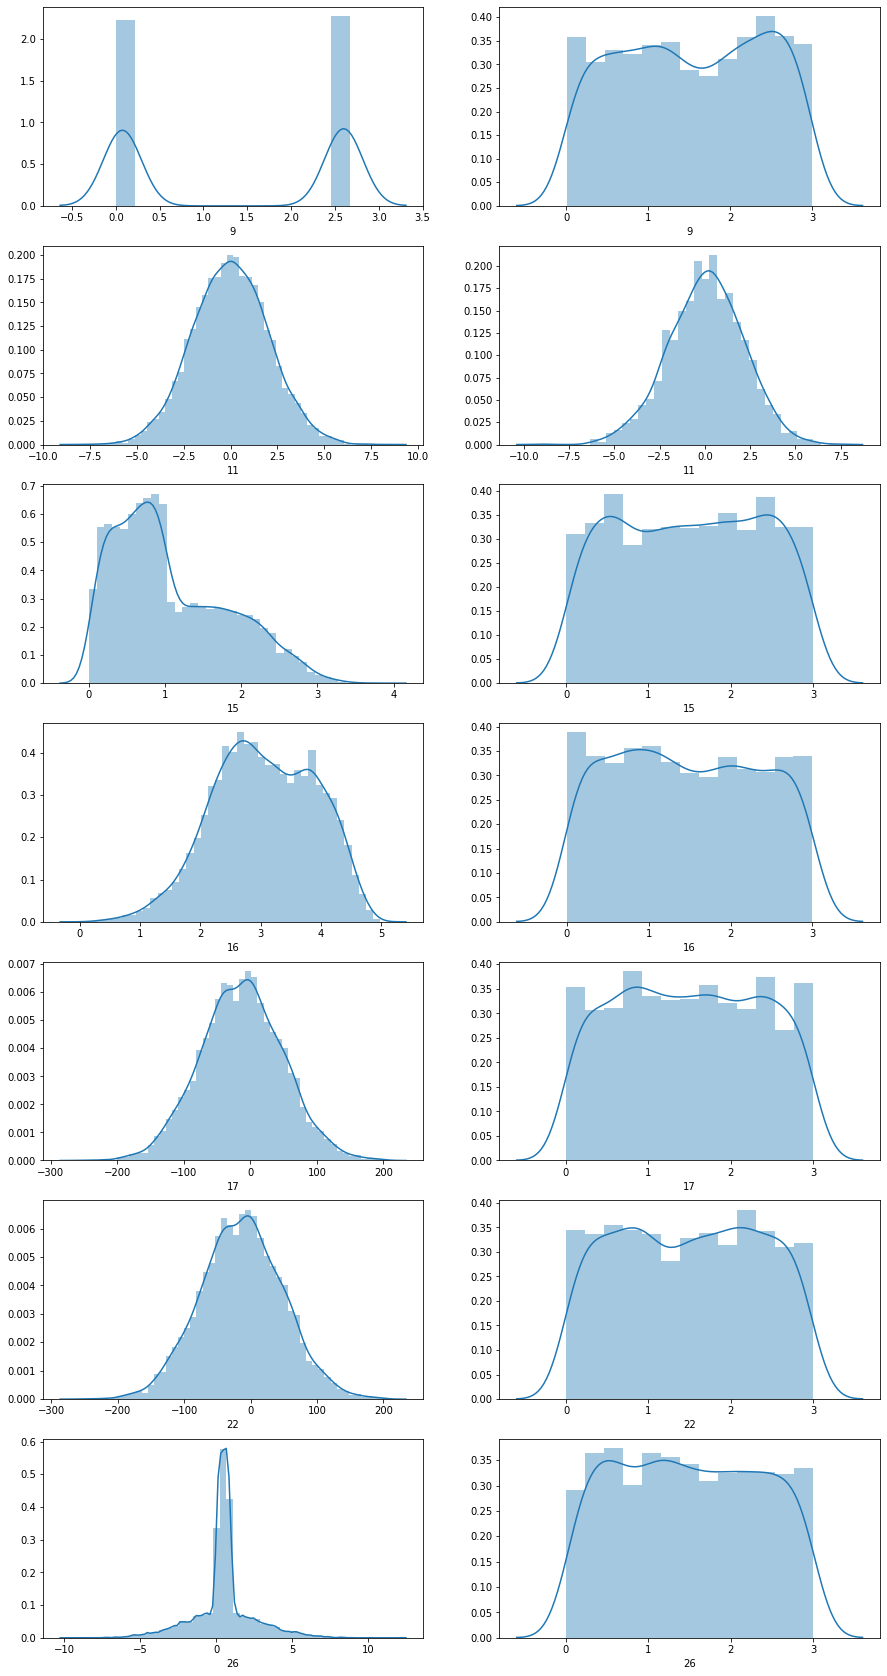

In [57]:
# Посмотрим на наши фичи
histograms(feature[0], train, test)

In [46]:
# Сравним наиболее коррелирующие фичи и отобранные регрессионным анализом
train["y"] = target
corr = correlation(train).index[1:8]
print(corr)
print(feature[0])

Index([9, 16, 15, 29, 19, 22, 17], dtype='object')
Int64Index([9, 11, 15, 16, 17, 22, 26], dtype='int64')


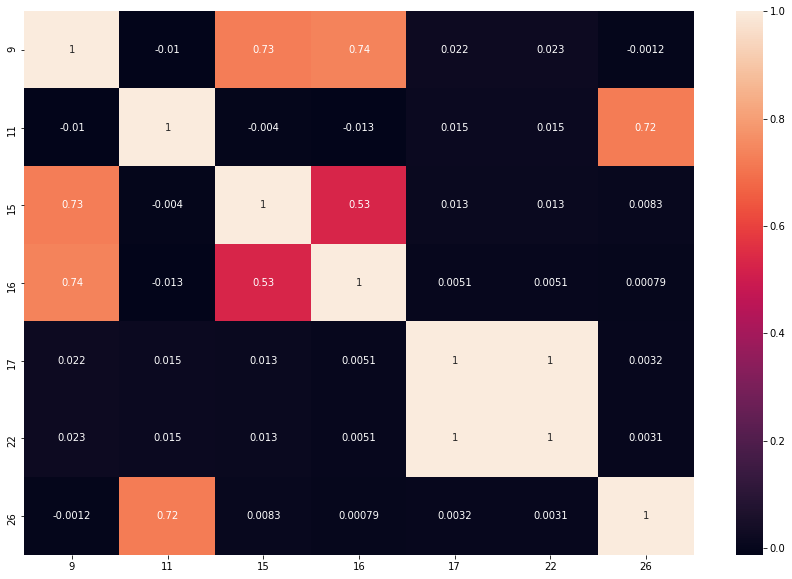

In [45]:
# Корреляция между отобранными фичами
figure(figsize=(15, 10))
sns.heatmap(train[feature[0]].corr(), annot=True)

# **Training**

In [ ]:
#pip install catboost

In [58]:
clf = CatBoostClassifier(iterations=500, random_state=42)

In [69]:
# Уберем наиболее не стандартные фичи
# Разобьем данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train.drop(feature[0], axis=1),
                                                    target,
                                                    test_size=0.3,
                                                    random_state=42)

In [70]:
clf.fit(X_train,
        y_train)

Learning rate set to 0.044651
0:	learn: 0.6878245	total: 9.86ms	remaining: 4.92s
1:	learn: 0.6816464	total: 19.5ms	remaining: 4.86s
2:	learn: 0.6768515	total: 29.3ms	remaining: 4.85s
3:	learn: 0.6713416	total: 39.1ms	remaining: 4.85s
4:	learn: 0.6664889	total: 48.8ms	remaining: 4.83s
5:	learn: 0.6612114	total: 58.2ms	remaining: 4.79s
6:	learn: 0.6575321	total: 67.5ms	remaining: 4.75s
7:	learn: 0.6538553	total: 77ms	remaining: 4.73s
8:	learn: 0.6507001	total: 86.3ms	remaining: 4.71s
9:	learn: 0.6459225	total: 95.4ms	remaining: 4.68s
10:	learn: 0.6410054	total: 105ms	remaining: 4.66s
11:	learn: 0.6384147	total: 114ms	remaining: 4.65s
12:	learn: 0.6347386	total: 124ms	remaining: 4.63s
13:	learn: 0.6306871	total: 133ms	remaining: 4.61s
14:	learn: 0.6280327	total: 142ms	remaining: 4.6s
15:	learn: 0.6248231	total: 152ms	remaining: 4.59s
16:	learn: 0.6221901	total: 161ms	remaining: 4.58s
17:	learn: 0.6197944	total: 170ms	remaining: 4.55s
18:	learn: 0.6173385	total: 182ms	remaining: 4.61s
19:	

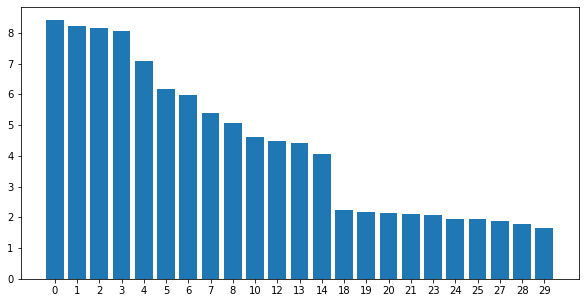

In [89]:
# Важность фич для catboost
HistFeatureImp(clf, (10, 5))

In [102]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"Score on test data {score}" %score)

Score on test data 0.8219523996733903


In [113]:
y = score
print("Points:", 100 if y > 0.82 else (40 + (y - 0.6) / 0.22 * 60 if y > 0.6 else 0))

Points: 100


# **Finally**

In [108]:
sub = pd.DataFrame()
predictions = clf.predict_proba(test.drop(feature[0], axis=1))[:, 1]
sub[predictions[0]] = predictions[1:]

In [114]:
sub.to_csv("submission.csv", index=False)
print("Done")

Done
